## Sentiment analysis based on LSTM

In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords 
from collections import Counter
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [95]:
data = pd.read_csv('../dataset/process/en-2020-01-merged-cleaned-without-emoji.tsv', sep='\t')

data = data.dropna()

X = data['text'].values
y = data['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Train size: {len(X_train)}')
print(f'Test size: {len(X_test)}')


Train size: 90768
Test size: 38901


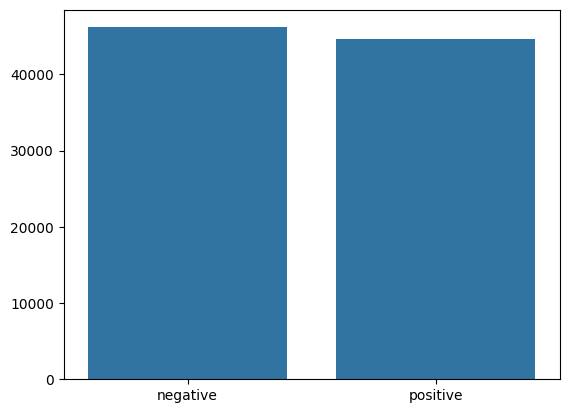

In [96]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [97]:
from torch.nn.utils.rnn import pad_sequence

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train, x_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train, final_list_test = [], []
    for sent in x_train:
        final_list_train.append(torch.tensor([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                              if preprocess_string(word) in onehot_dict.keys()]))
    for sent in x_val:
        final_list_test.append(torch.tensor([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                             if preprocess_string(word) in onehot_dict.keys()]))
    
    # Padding sequences to the same length
    final_list_train = pad_sequence(final_list_train, batch_first=True, padding_value=0)
    final_list_test = pad_sequence(final_list_test, batch_first=True, padding_value=0)
    
    return final_list_train, final_list_test, onehot_dict

X_train_tk, X_test_tk, onehot_dict = tockenize(X_train, y_train, X_test, y_test)

In [98]:
print(f'X_train_tk shape: {X_train_tk.shape}')
print(f'X_test_tk shape: {X_test_tk.shape}')
print (f'Onehot_dict length: {len(onehot_dict)}')

X_train_tk shape: torch.Size([90768, 20])
X_test_tk shape: torch.Size([38901, 19])
Onehot_dict length: 1000


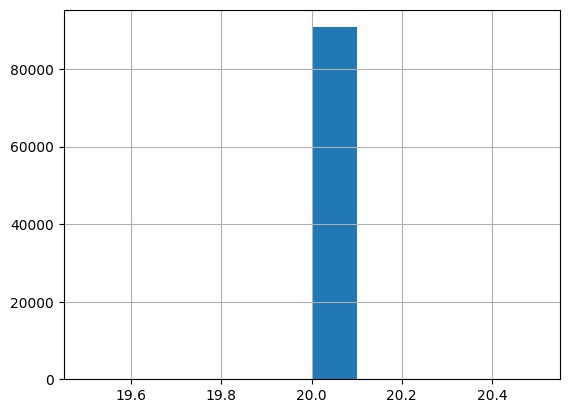

tensor([ 86, 304,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])


In [99]:
rev_len = [len(i) for i in X_train_tk]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

print(X_train_tk[0])

In [100]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_tk.numpy()), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_tk.numpy()), torch.from_numpy(y_test))
# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [101]:
# obtain one batch of training data
sample_x, sample_y = next(iter(train_loader))

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 20])
Sample input: 
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [  8,   6,   3,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [  3,   5, 629,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [105, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [152,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 58, 398,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 17,  89,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 37, 142,   7,  10, 290,   1,  33, 165,  96,   1, 356,   0,   0,   0,
           0,   0,   0,   0,   

In [102]:
no_layers = 2
vocab_size = len(onehot_dict) + 1
embedding_dim = 100
output_dim = 1
hidden_dim = 256


In [103]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [104]:
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)
model.to(device)

# Loss and optimization
lr = 0.001
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [105]:
# Accuracy function
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item() / len(label)

# Training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, batch in enumerate(tqdm(iterator, desc="Training")):
        optimizer.zero_grad()
        tweet, labels = batch
        labels = labels.type(torch.FloatTensor)
        tweet, labels = tweet.to(device), labels.to(device)
        hidden = model.init_hidden(labels.shape[0])
        output, hidden = model(tweet, hidden)
        loss = criterion(output.squeeze(), labels)
        accura = acc(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += accura
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator, desc="Evaluating")):
            tweet, labels = batch
            labels = labels.type(torch.FloatTensor)
            tweet, labels = tweet.to(device), labels.to(device)
            hidden = model.init_hidden(labels.shape[0])
            output, hidden = model(tweet, hidden)
            loss = criterion(output.squeeze(), labels.squeeze())
            accura = acc(output, labels)
            epoch_loss += loss.item()
            epoch_acc += accura
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [106]:
# Training the model
N_EPOCHS = 10
best_valid_loss = float('inf')

train_epoch_losses = []
train_epoch_accs = []
val_epoch_losses = []
val_epoch_accs = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)
    train_epoch_losses.append(train_loss)
    train_epoch_accs.append(train_acc)
    val_epoch_losses.append(valid_loss)
    val_epoch_accs.append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Evaluating: 100%|██████████| 779/779 [00:05<00:00, 151.50it/s]


	Train Loss: 0.689 | Train Acc: 51.97%
	 Val. Loss: 0.626 |  Val. Acc: 64.27%


Evaluating: 100%|██████████| 779/779 [00:05<00:00, 130.32it/s]


	Train Loss: 0.593 | Train Acc: 67.35%
	 Val. Loss: 0.574 |  Val. Acc: 68.46%


Evaluating: 100%|██████████| 779/779 [00:06<00:00, 118.42it/s]


	Train Loss: 0.565 | Train Acc: 69.65%
	 Val. Loss: 0.572 |  Val. Acc: 68.85%


Evaluating: 100%|██████████| 779/779 [00:07<00:00, 110.22it/s]


	Train Loss: 0.546 | Train Acc: 70.97%
	 Val. Loss: 0.575 |  Val. Acc: 68.53%


Evaluating: 100%|██████████| 779/779 [00:06<00:00, 120.86it/s]


	Train Loss: 0.521 | Train Acc: 72.57%
	 Val. Loss: 0.586 |  Val. Acc: 68.18%


Evaluating: 100%|██████████| 779/779 [00:07<00:00, 107.16it/s]


	Train Loss: 0.491 | Train Acc: 74.34%
	 Val. Loss: 0.626 |  Val. Acc: 67.95%


Evaluating: 100%|██████████| 779/779 [00:06<00:00, 113.43it/s]


	Train Loss: 0.458 | Train Acc: 76.11%
	 Val. Loss: 0.667 |  Val. Acc: 67.68%


Evaluating: 100%|██████████| 779/779 [00:07<00:00, 99.00it/s] 


	Train Loss: 0.429 | Train Acc: 77.46%
	 Val. Loss: 0.691 |  Val. Acc: 67.35%


Evaluating: 100%|██████████| 779/779 [00:07<00:00, 106.14it/s]


	Train Loss: 0.408 | Train Acc: 78.67%
	 Val. Loss: 0.758 |  Val. Acc: 66.77%


Evaluating: 100%|██████████| 779/779 [00:10<00:00, 74.38it/s] 

	Train Loss: 0.389 | Train Acc: 79.48%
	 Val. Loss: 0.805 |  Val. Acc: 67.03%


# draw result

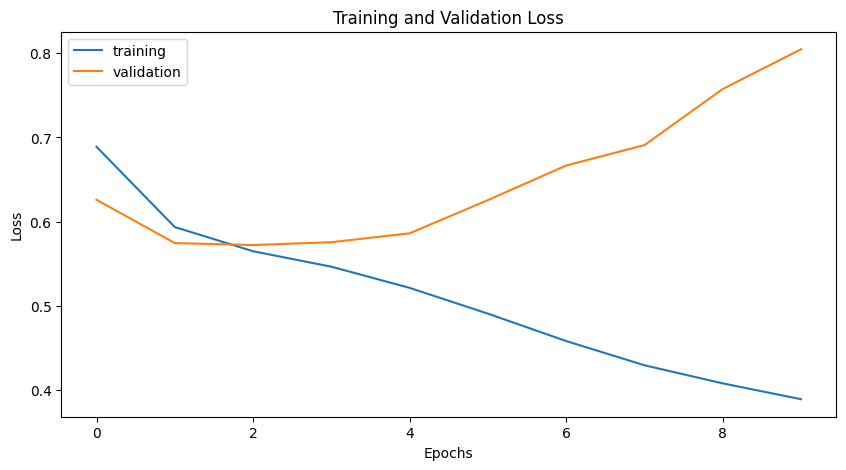

In [107]:
# losses and accuracies
# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_epoch_losses, label="training")
plt.plot(val_epoch_losses, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


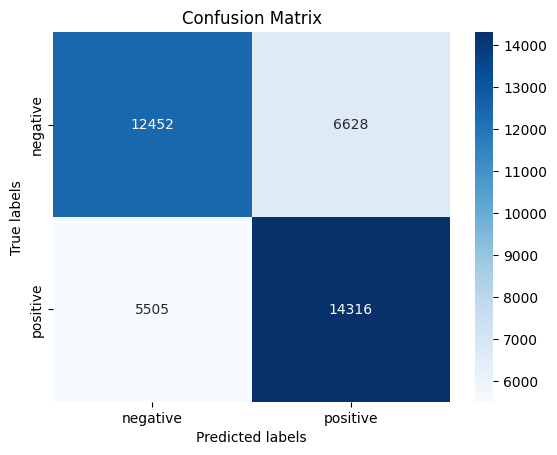

Accuracy: 68.81%


In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')  # annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['negative', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'positive'])

# Make predictions
model.load_state_dict(torch.load('saved_weights.pt'))
model.eval()

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for i, (tweet, labels) in enumerate(test_loader):
        tweet, labels = tweet.to(device), labels.to(device)
        hidden = model.init_hidden(labels.shape[0])
        output, hidden = model(tweet, hidden)
        y_pred_tag = torch.round(output)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

# Flatten the lists and ensure they are integers
y_pred_list = [int(item) for sublist in y_pred_list for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]
y_true_list = [int(item) for sublist in y_true_list for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]

plot_confusion_matrix(y_true_list, y_pred_list)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true_list, y_pred_list)
print(f'Accuracy: {accuracy*100:.2f}%')



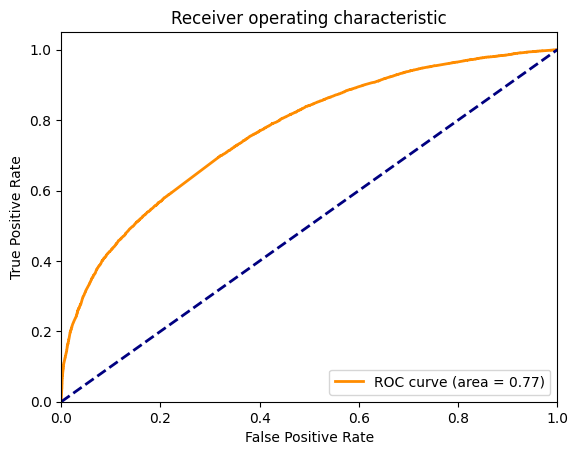

In [109]:
# roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Make predictions
model.load_state_dict(torch.load('saved_weights.pt'))
model.eval()

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for i, (tweet, labels) in enumerate(test_loader):
        tweet, labels = tweet.to(device), labels.to(device)
        hidden = model.init_hidden(labels.shape[0])
        output, hidden = model(tweet, hidden)
        y_pred_list.append(output.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

# Flatten the lists
y_pred_list = [item for sublist in y_pred_list for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]
y_true_list = [item for sublist in y_true_list for item in (sublist if isinstance(sublist, (list, np.ndarray)) else [sublist])]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_list, y_pred_list)
roc_auc = roc_auc_score(y_true_list, y_pred_list)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()